# Experimental data processing for dissertation

This notebook adds a principal component analysis preprocessing step to the experimental data pipeline to truncate the dimensionality and speed up computation. It is shown to have performance improvements in prediction when compared with the none PCA models.

Number of data instances calculation: there will be a maximum total of 20,160 data elements. However, it will be possible to combine time-adjacent spectra to increase `spec_time` at the expense of `num_specs`. This tradeoff will be explored later.

In [2]:
spec_time = 180 #seconds
measure_time = 50*3600 # seconds
num_specs = measure_time / spec_time
num_samples = 7
num_instances = num_specs * num_samples
num_instances

7000.0

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scikitplot as skplt
import time
warnings.simplefilter(action='ignore')  
sns.set_context("talk")
sns.set_style("dark")
pd.set_option('display.max_columns', 100)
# Models I will use
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA

# Various other tools in sklearn I will use
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import os
import numpy as np
from collections import OrderedDict
import sys
from glob import glob
print(sys.version)

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


In [4]:
np.set_printoptions(threshold=sys.maxsize)

In general, it is a bad idea to make dynamically-named variables through a for loop iteration. Rather, it is advised to build a dictionary. So, let's do that...

Here is code that works for generating the dictionary containing all 7000 spectra.

In [5]:
def spc_bin_collater(spec_factor, bin_factor):
    # Generate a dictionary containing all of the relevant spectra 
    # in the working directory
    dct = OrderedDict() # 7,000 secta with 8,192 bins each
    new_dct = OrderedDict() # 
    fnl_dct = OrderedDict()
    rootdir = 'C:\\Users\\awdre\\Documents\\data'
    paths = glob('*/')
    os.chdir(rootdir)
    dct = OrderedDict()
    for path in paths:
        os.chdir(path)
        for filename in sorted(os.listdir(os.getcwd())):
            if filename.endswith(".Spe"):
                np_data = np.genfromtxt(filename, skip_header=12, skip_footer=14)
                dct['%s' % filename] = np_data
            else:
                pass
        os.chdir(rootdir)
    # Down-bin the individual spectra according to bin_factor 
    # and save as new dictionary
    for key in dct.keys():
        X = dct['%s' % key]
        X_db = np.array([sum(X[i:i+bin_factor]) 
                         for i in range(0, len(X)) if i % bin_factor == 0])
        new_dct['%s' % key] = X_db
    # Collate multiple spectra into a single spectrum according to 
    # spec_factor
    # Let's separate the dictionary keys and values into numpy arrays
    keys = np.array(list(new_dct.keys()))
    values = np.array(list(new_dct.values()))
    X_ds = np.array([sum(values[i:i+spec_factor,:]) 
                     for i in range(0, len(keys)) if i % spec_factor == 0])
    y = []
    for key in keys:
        if 'V0322' in key:
            y = np.append(y, 0.0071)
        elif 'V0324' in key:
            y = np.append(y, 0.03)
        elif 'V0328' in key:
            y = np.append(y, 0.0002)
        elif 'V0332' in key:
            y = np.append(y, 0.20)
        elif 'V0336' in key:
            y = np.append(y, 0.50)
        elif 'V0340' in key:
            y = np.append(y, 0.63)
        elif 'V0344' in key:
            y = np.append(y, 0.97)
        else:
            print("Error!")
    
    y_ds = np.array([y[i] for i in range(0,len(y)) if i % spec_factor == 0])
    return new_dct, keys, values, X_ds, y_ds
        

In [6]:
def one_d_scaler(X_train, X_test):
    """This function performs normalization across features per instance,
    and scaling to zero-centered with unit variance across instances per 
    feature."""
    for x in [X_train, X_test]: # Normalization
        total = np.sum(x, axis=1)
        for i in range(0,len(x[:,0])):
            x[i] = x[i] / total[i]
    return X_train, X_test

In [7]:
def reg_comp(seed, X_train, y_train, X_test, y_test, ridge, 
             decision_tree, lasso, elastic_net, random_forest,
            adaboost_reg):
    """This is the help documentation for regression comparison"""
    seed = seed

    models = []
    models.append(('Ridge', ridge))    
    models.append(('Lasso', lasso))
    models.append(('Elastic Net', elastic_net))
    # models.append(('Support Vector', SVR(kernel='linear')))
    models.append(('Decision Tree', decision_tree))
    models.append(('Random Forest', random_forest))
    # models.append(('PCA Random Forest', pca_random_forest))
    models.append(('AdaBoost Forest', adaboost_reg))

    results = []
    names = []
    scoring = 'neg_mean_absolute_error'
    
    print("Model: Mean (Standard Deviation)")

    for name, model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        result = abs(pred - y_test)
        results.append(result)
        names.append(name)
        msg = "%s: %f (%f)" % (name, result.mean(), result.std())
        print(msg)

    sns.set(style="darkgrid")
    fig = plt.figure(figsize=(6, 6), dpi=1200)
    fig.suptitle("Regression Algorithm Performance Comparison")
    ax = fig.add_subplot(111)
    # sns.boxplot(data=results_cc_reg, linewidth=1, color='orange')
    sns.violinplot(data=results, cut=0, width=1, linewidth=.8,
                   inner='point', orient='h', scale='area')
    ax.set_yticklabels(names)
    plt.xscale('linear')
    plt.xlabel("MAE")
    plt.xlabel("Absolute Prediction Error Distribution")
    plt.xticks(rotation=30)
    plt.yticks(rotation=0)
#    plt.savefig('ORNL_figures/regression_comparison.png')
    plt.show()

    return results, names

In [8]:
def model_gsearch_cval(model, X_train, y_train, param_grid, cv, scorer):
    grid_search = GridSearchCV(model, param_grid, cv=cv,
                               scoring=scorer)
    grid_search.fit(X_train, y_train)
    gs_results = pd.DataFrame(grid_search.cv_results_).sort_values(
        by=['rank_test_score'])
    grid_search.best_estimator_
    scores = cross_val_score(
                grid_search.best_estimator_, X_train, y_train, cv=cv,
                scoring=scorer)
    # rmse_scores = np.sqrt(-scores)
    mae = scores.mean()
    Message = print("Cross-validation statistics for best model:",
                    'Scores:', scores, 'Mean:', scores.mean(), 
                    'Standard Deviation:', scores.std())
    return gs_results, grid_search.best_estimator_, grid_search, Message, mae

In [9]:
def full_pipeline(spec_factor, bin_factor, test_size, seed):
    new_dct, keys, values, X_ds, y_ds = spc_bin_collater(spec_factor, bin_factor)
    
    X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size=test_size, random_state=seed)
    
    X_train, X_test = one_d_scaler(X_train, X_test)
    
    return X_train, X_test, y_train, y_test

# 1400 spectrum dataset, 128 dimensional feature space

In [11]:
X_train, X_test, y_train, y_test = full_pipeline(spec_factor=5, bin_factor=1, test_size=0.2, seed=42)

We select the top 10 components as determined by PCA to account for over 99 percent of the inherent variation in the data.

In [12]:
pca = PCA(random_state=42, n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [13]:
sns.set(context="paper")

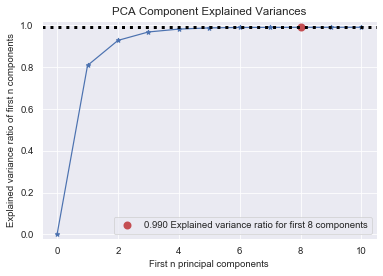

In [14]:
skplt.decomposition.plot_pca_component_variance(pca,
                                                target_explained_variance=0.99)


In [15]:
x = np.linspace(1,8193,8192)
E = 0.390988*x+0.888569
E = np.round(E, decimals=1)

In [16]:
df = pd.DataFrame(index=E, data=pca.components_[0:3, :].T, columns=['First Component', 'Second Component', 'Third Component'])

In [17]:
df_abs = abs(df)

In [18]:
df1 = df_abs.nlargest(10, 'First Component')

In [19]:
df2 = df_abs.nlargest(10, 'Second Component')

In [20]:
df3 = df_abs.nlargest(10, 'Third Component')

In [21]:
dfs = pd.concat([df1, df2, df3]).drop_duplicates()

Text(0, 0.5, 'Feature Energy [keV]')

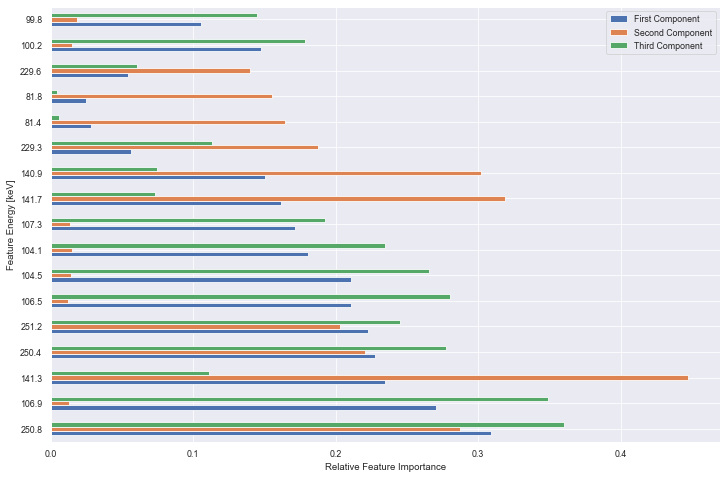

In [22]:
dfs.plot.barh(figsize=(12, 8))
plt.xlabel("Relative Feature Importance")
plt.ylabel("Feature Energy [keV]")

In [23]:
sns.set(context="talk")

In [24]:
fig = plt.figure(figsize=(12, 8), dpi=1200)
sns.lineplot(x=E, y=pca.components_[0], linewidth=0.5, color='blue')
sns.lineplot(x=E, y=pca.components_[1], linewidth=0.5, color='orange')
sns.lineplot(x=E, y=pca.components_[2], linewidth=0.5, color='green')
plt.legend(labels=["First PC", "Second PC", "Third PC"])
plt.xlabel("Energy [keV]")
plt.xlim(0,2000)
plt.ylabel("Principal component feature coefficients")
plt.title("Feature contributions to the top three principal components")
plt.show()

# Ridge Regression

In [25]:
param_grid=[{
    'alpha': [1e-7, 5e-7, 6e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1,
              1, 10, 1e2, 2,
              1e3, 1.1e3, 1e4, 1e5,], 
    'solver': ['auto', 'svd', 'cholesky']
}]

results_ridge, best_ridge, ridge_search, Message, mae= model_gsearch_cval(
    model=Ridge(random_state=42), X_train=X_train, y_train=y_train,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

Cross-validation statistics for best model: Scores: [-0.04800352 -0.05401209 -0.05411387 -0.05247435 -0.05090062] Mean: -0.051900888625435695 Standard Deviation: 0.0022747906270310712


In [26]:
best_ridge

Ridge(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='svd', tol=0.001)

<Figure size 7200x4800 with 0 Axes>

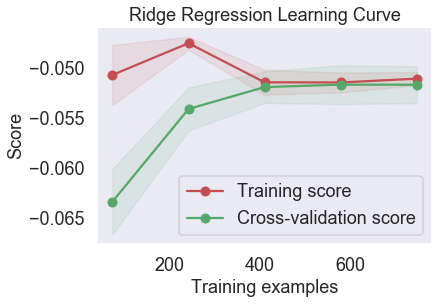

In [27]:
fig = plt.figure(figsize=(6,4), dpi=1200)
skplt.estimators.plot_learning_curve(best_ridge, X_train, y_train,
                                    scoring="neg_mean_absolute_error")
plt.title('Ridge Regression Learning Curve')
plt.show()

# Lasso

In [28]:
param_grid = [{
    'alpha': [1e-9, 1e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 1e-6, 5e-6, 1e-5], 
    'random_state': [42],
    'tol': [1, 1e-1, .02, .03, .04, .05, .06, .07, 0.08, .09, 1e-2, 1e-3],
    'max_iter': [10, 1e2, 1e3]
}]

results_lasso, best_lasso, lasso_search, Message, mae = model_gsearch_cval(
    model=Lasso(),X_train=X_train, y_train=y_train,
     param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

Cross-validation statistics for best model: Scores: [-0.04876246 -0.05446752 -0.05584128 -0.0528731  -0.05063249] Mean: -0.05251537069944625 Standard Deviation: 0.002554607796645929


In [29]:
best_lasso

Lasso(alpha=2e-07, copy_X=True, fit_intercept=True, max_iter=10,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.001, warm_start=False)

<Figure size 7200x4800 with 0 Axes>

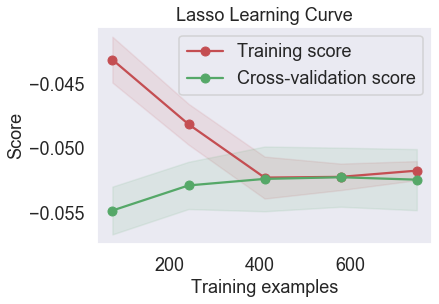

In [30]:
fig = plt.figure(figsize=(6,4), dpi=1200)
skplt.estimators.plot_learning_curve(best_lasso, X_train, y_train,
                                    scoring="neg_mean_absolute_error")
plt.title('Lasso Learning Curve')
plt.show()

# Elastic Net

In [31]:
param_grid = [{
    'alpha': [1e-11, 1e-10, 5e-9, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4], 
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'random_state': [42],
    'max_iter': [1000],
    'tol': [1e-1, 1e-2, 1e-3, 1e-4]
}]

results_elastic, best_elastic, elastic_search, Message, mae = model_gsearch_cval(
    model=ElasticNet(), X_train=X_train, y_train=y_train,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

Cross-validation statistics for best model: Scores: [-0.0479495  -0.05407105 -0.05327094 -0.05232822 -0.05160915] Mean: -0.051845770734402344 Standard Deviation: 0.002119085258014049


In [32]:
best_elastic

ElasticNet(alpha=1e-07, copy_X=True, fit_intercept=True, l1_ratio=0.8,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False)

<Figure size 7200x4800 with 0 Axes>

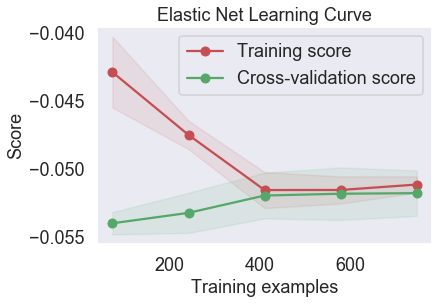

In [33]:
fig = plt.figure(figsize=(6,4), dpi=1200)
skplt.estimators.plot_learning_curve(best_elastic, X_train, y_train,
                                    scoring="neg_mean_absolute_error")
plt.title('Elastic Net Learning Curve')
plt.show()

# Decision Tree Regressor

In [34]:
tick = time.time()
param_grid= [{
    'criterion': ['mae'], 'splitter': ['best'], 
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],  
    'min_samples_split': [2], 'min_samples_leaf': [2, 5, 7, 10, 20], 
    'max_features': [None], 'max_leaf_nodes': [10, 15, 30], 
    'random_state': [42]
}]

results_tree_reg, best_tree_reg, tree_search, Message, mae = model_gsearch_cval(
    model=DecisionTreeRegressor(), X_train=X_train, y_train=y_train,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")
tock = time.time()
print("This grid-search took:", tock-tick, "seconds.")

Cross-validation statistics for best model: Scores: [-0.00401786 -0.00191964 -0.00125    -0.00232143 -0.00058036] Mean: -0.002017857142857143 Standard Deviation: 0.001162567202358642
This grid-search took: 25.839519262313843 seconds.


In [35]:
best_tree_reg

DecisionTreeRegressor(criterion='mae', max_depth=6, max_features=None,
                      max_leaf_nodes=15, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

<Figure size 7200x4800 with 0 Axes>

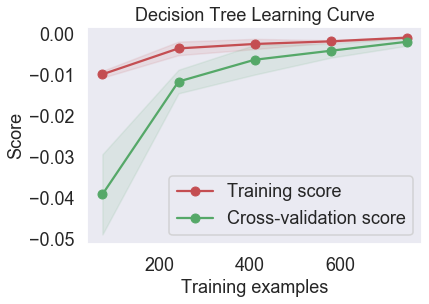

In [36]:
fig = plt.figure(figsize=(6,4), dpi=1200)
skplt.estimators.plot_learning_curve(best_tree_reg, X_train, y_train,
                                    scoring="neg_mean_absolute_error")
plt.title('Decision Tree Learning Curve')
# plt.savefig('exp_figures/tree_learning_curve.png')
plt.show()

In [37]:
import os
graphviz_dir = r'C:\Users\awdre\Anaconda3\Library\bin\graphviz'
os.environ['PATH'] += os.pathsep + graphviz_dir

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

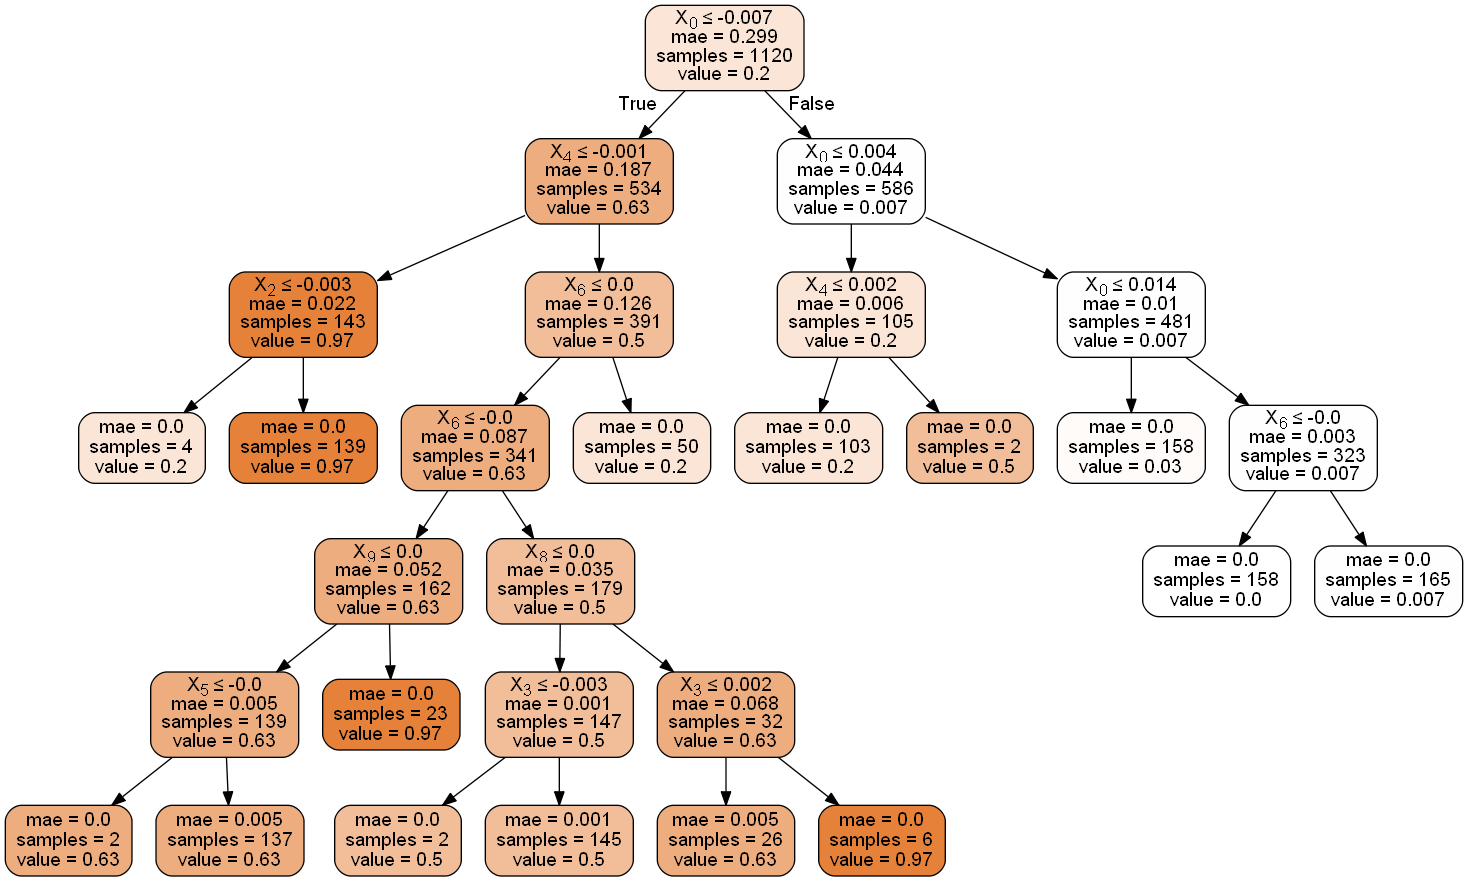

In [38]:
dot_data = StringIO()
export_graphviz(best_tree_reg, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Text(0, 0.5, 'Gamma-ray energy [keV]')

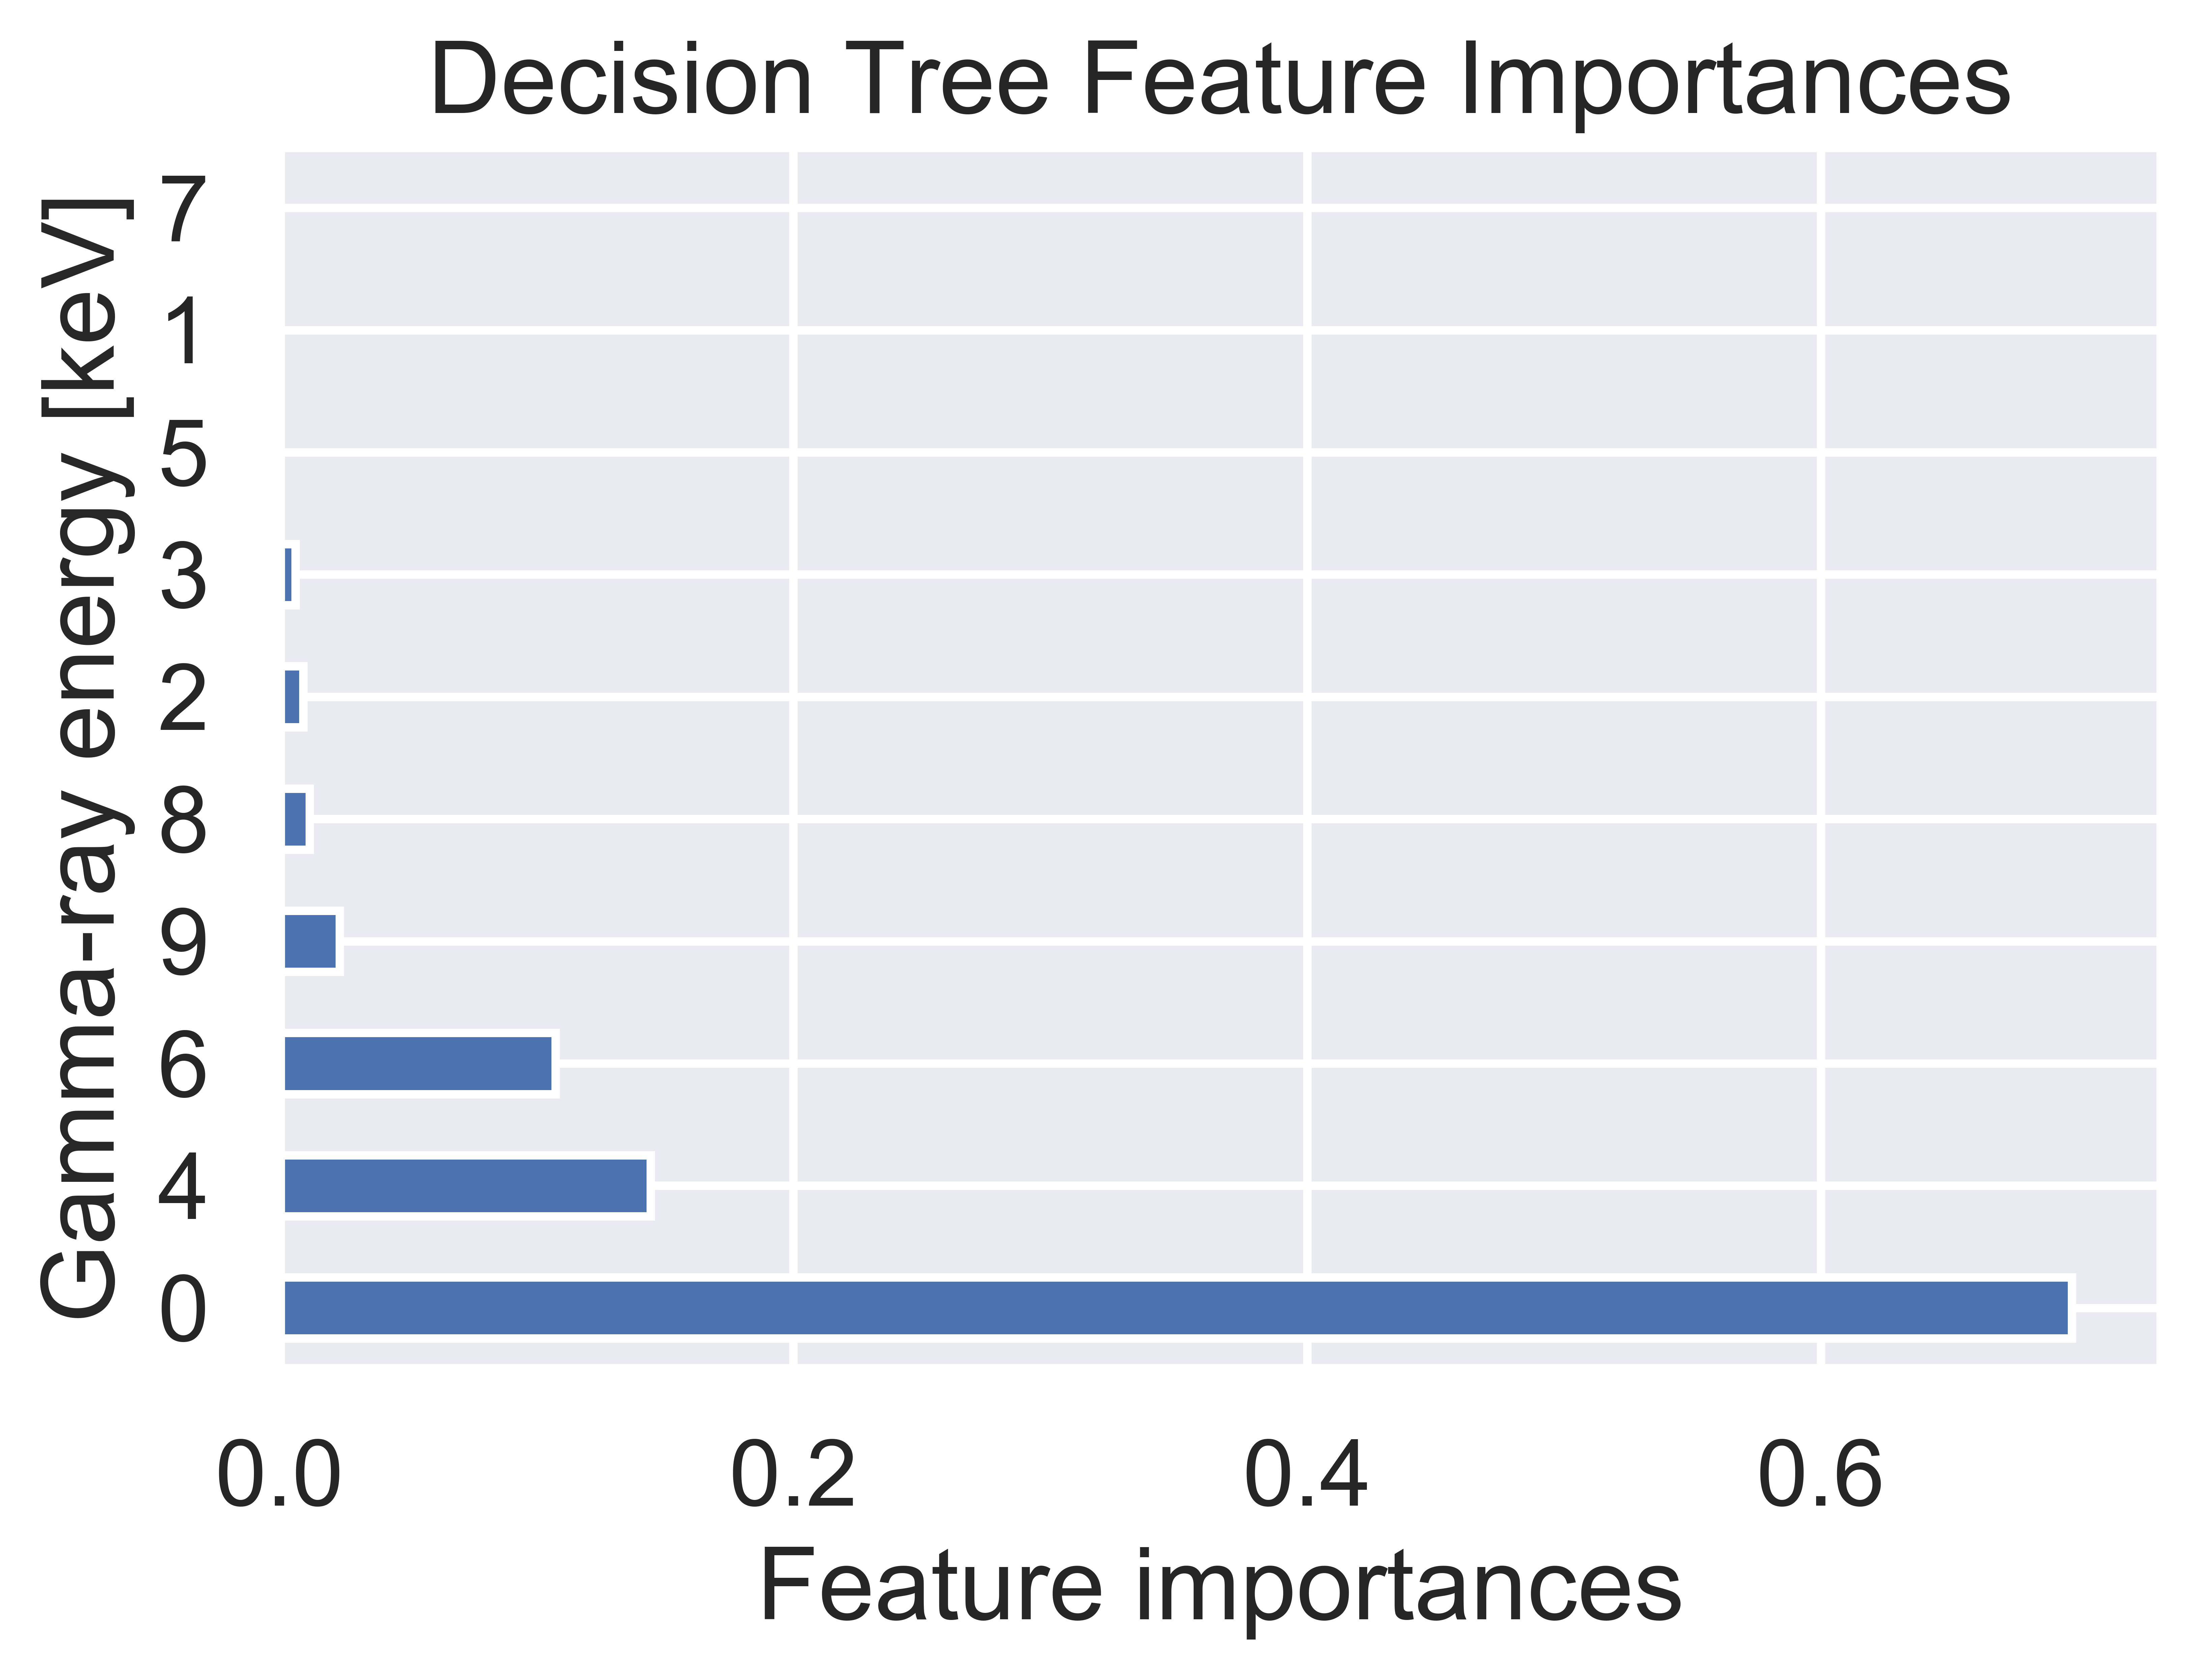

In [39]:
fig = plt.figure(figsize=(6,4), dpi=1200)
feat_importances = pd.Series(best_tree_reg.feature_importances_)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Decision Tree Feature Importances")
plt.xlabel("Feature importances")
plt.ylabel("Gamma-ray energy [keV]")

# Random Forest Regressor

In [40]:
t = time.time()

param_grid= [{
    'n_estimators': [32, 64],
    'criterion': ['mae'], 
    'max_depth': [2, 3, 4, 5, 6, 7, 8],  
    'min_samples_split': [2], 
    'min_samples_leaf': [5, 10, 20], 
    'max_features': [None], 
    'max_leaf_nodes': [15, 30],
    'random_state': [42],
    'n_jobs': [-1]
}]

results_for_reg, best_for_reg, for_search, Message, mae = model_gsearch_cval(
    model=RandomForestRegressor(), X_train=X_train, y_train=y_train,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

elapsed = time.time() - t
print(elapsed)

Cross-validation statistics for best model: Scores: [-0.01173898 -0.02184946 -0.01990932 -0.01910645 -0.02267508] Mean: -0.019055856584821486 Standard Deviation: 0.0038773872753126086
182.4012680053711


In [41]:
best_for_reg

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=30,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

<Figure size 7200x4800 with 0 Axes>

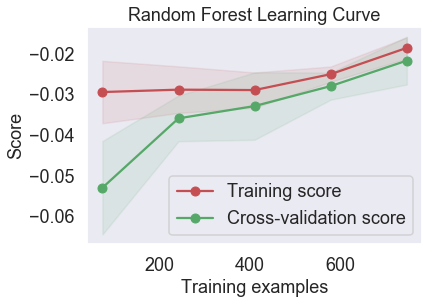

In [42]:
fig = plt.figure(figsize=(6,4), dpi=1200)
skplt.estimators.plot_learning_curve(best_for_reg, X_train, y_train,
                                    scoring="neg_mean_absolute_error")
plt.title('Random Forest Learning Curve')
plt.show()

Text(0, 0.5, 'Gamma-ray energy [keV]')

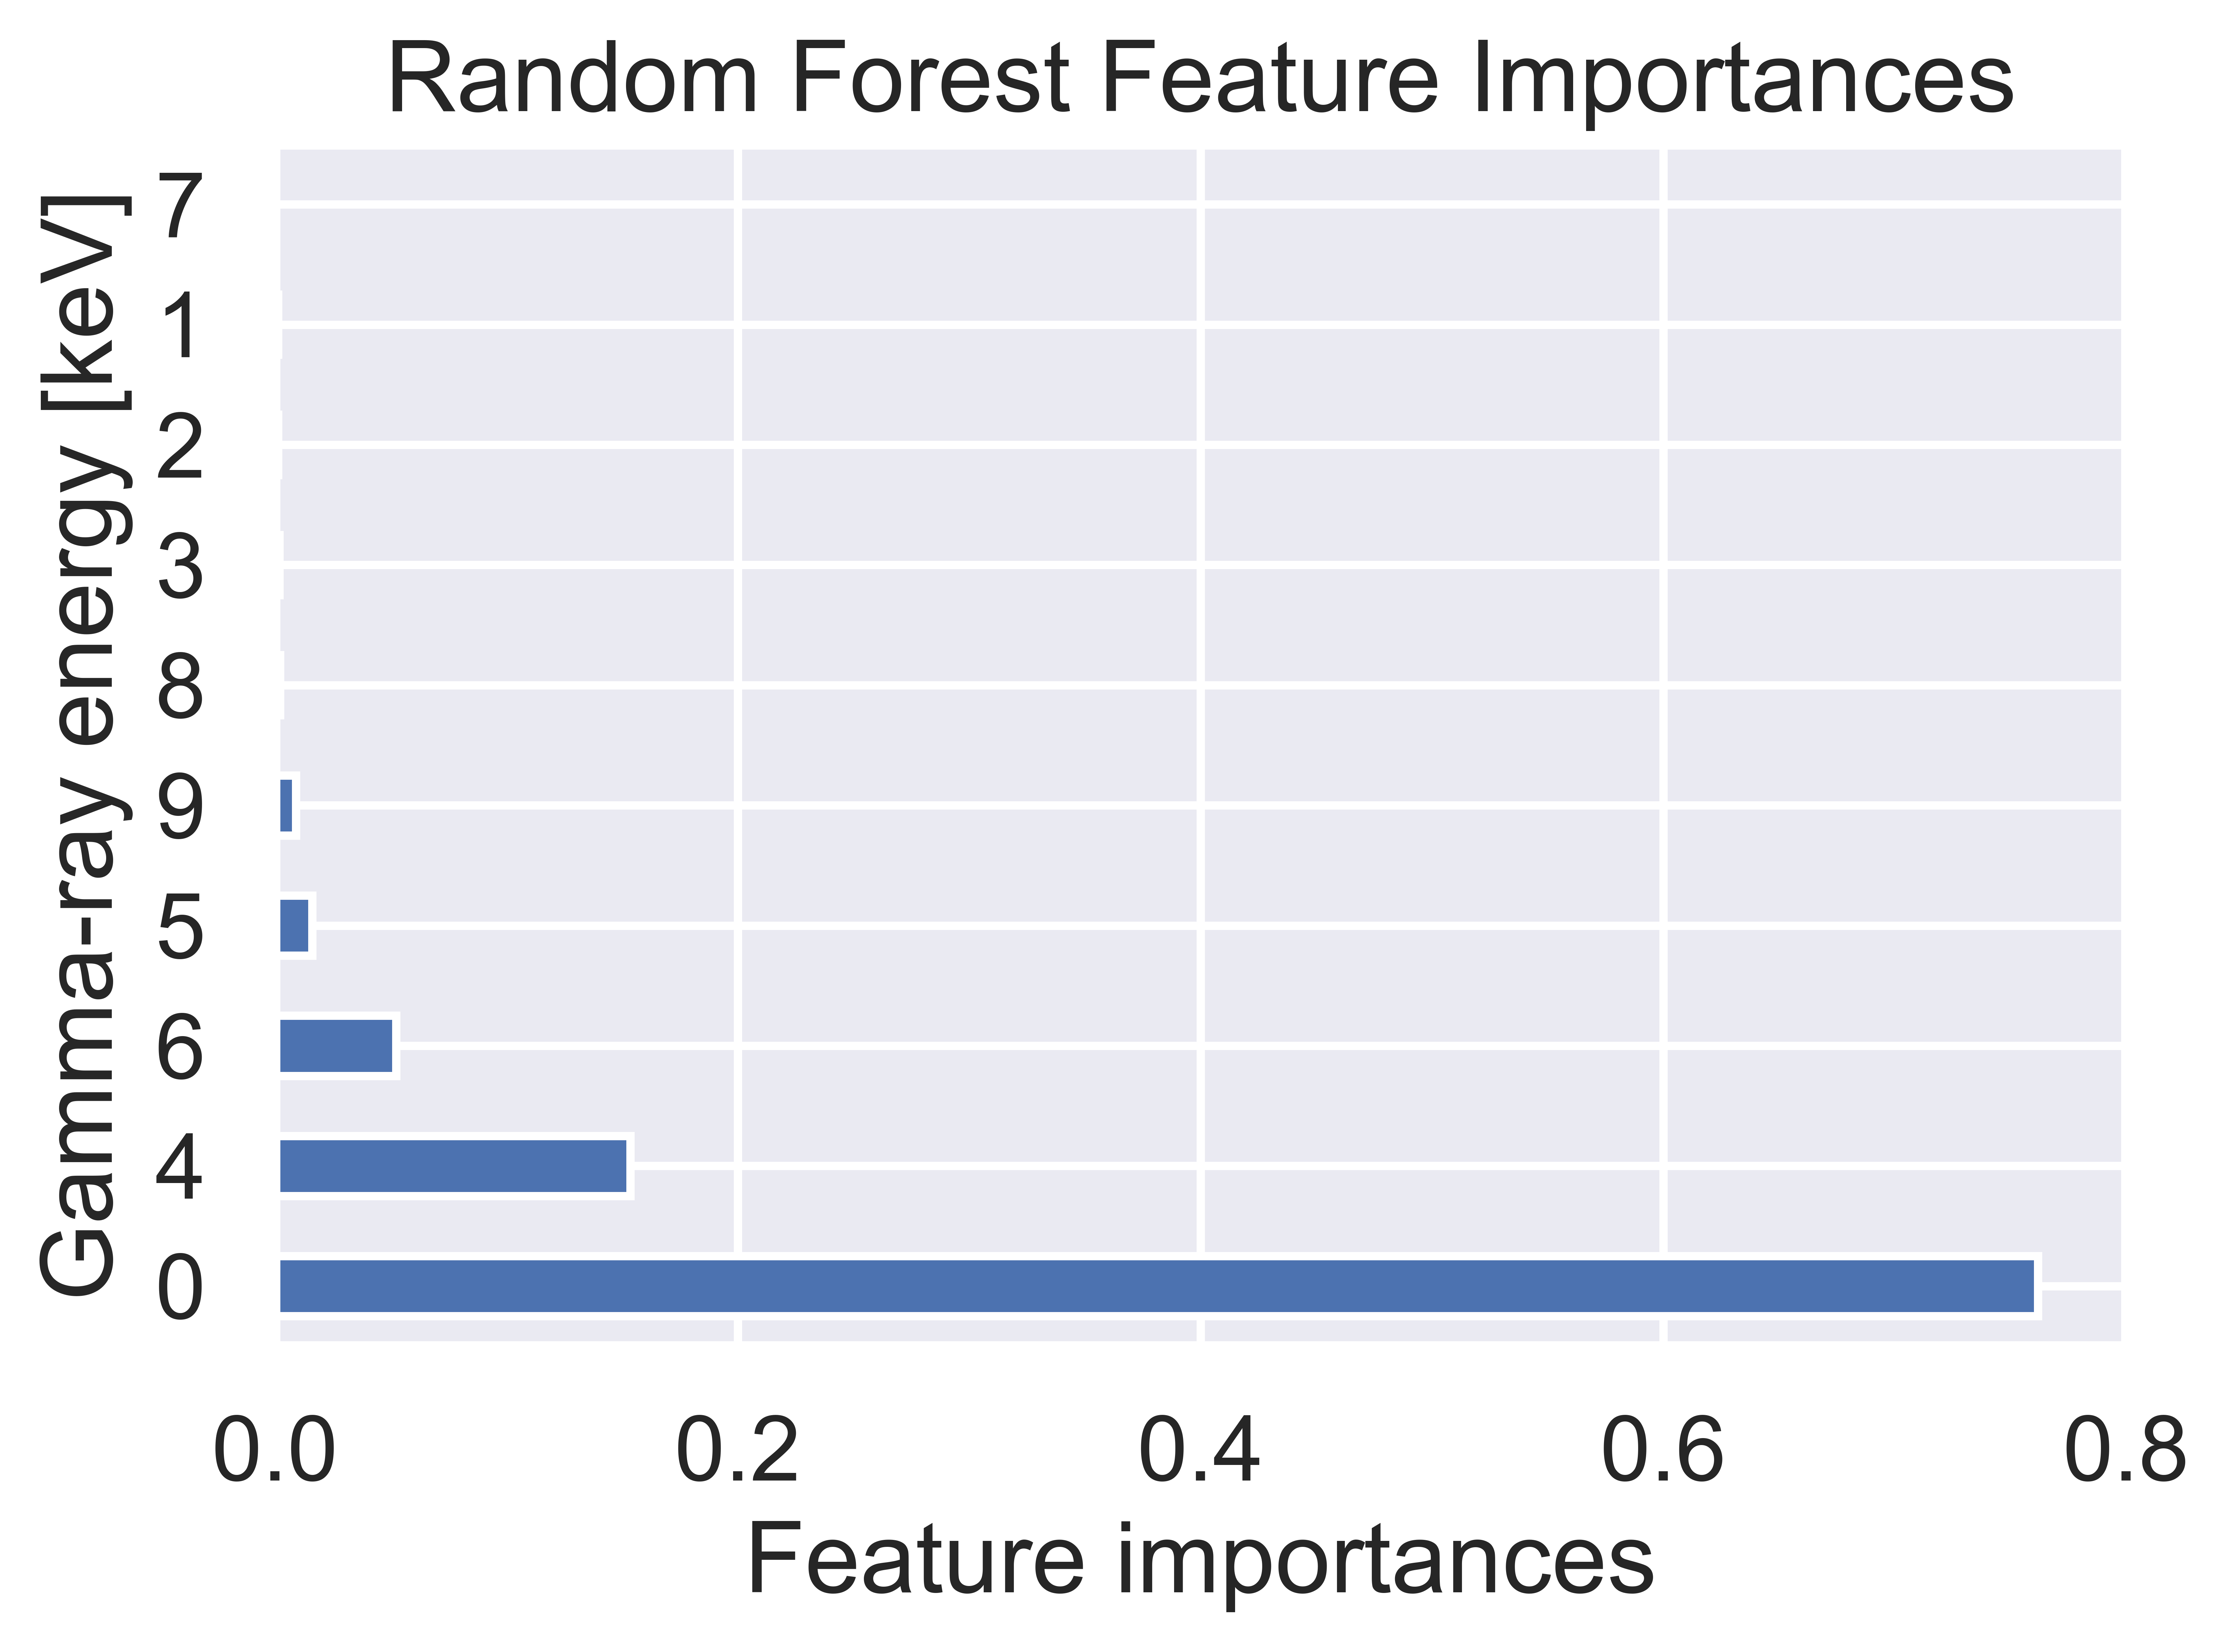

In [43]:
fig = plt.figure(figsize=(6,4), dpi=1200)
feat_importances = pd.Series(best_for_reg.feature_importances_)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.xlabel("Feature importances")
plt.ylabel("Gamma-ray energy [keV]")

# Adaptive Boosting

In [44]:
best_for_reg

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=30,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [45]:
tick = time.time()
ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(
                                criterion='mae',
                                max_depth=8,
                                max_features=None,
                                max_leaf_nodes=30,
                                min_samples_leaf=5,
                                min_samples_split=2,
                                random_state=42),
                            n_estimators=3,
                            learning_rate=.5,
                            random_state=42
                           )
score = cross_val_score(ada_reg, X=X_train, y=y_train, cv=5,
                       scoring='neg_mean_absolute_error')
print("The cross-validation MAE scores are:", score)
print("The average CV MAE score is:", np.mean(score))
tock = time.time() - tick
print("This process took: ", tock, " seconds.")

The cross-validation MAE scores are: [-0.00058036 -0.00133929 -0.00191964 -0.00174107 -0.00116071]
The average CV MAE score is: -0.0013482142857142857
This process took:  0.37399864196777344  seconds.


<Figure size 7200x4800 with 0 Axes>

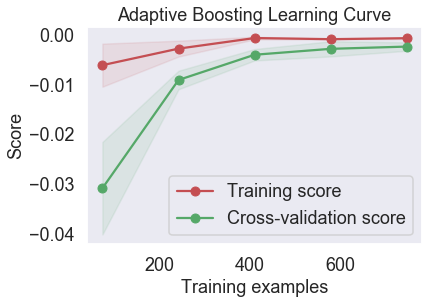

In [46]:
fig = plt.figure(figsize=(6,4), dpi=1200)
skplt.estimators.plot_learning_curve(ada_reg, X_train, y_train,
                                    scoring="neg_mean_absolute_error")
plt.title('Adaptive Boosting Learning Curve')
plt.show()

In [47]:
best_ada_score = -0.0013482142857142857
best_ada_reg = ada_reg
best_ada_reg

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae',
                                                       max_depth=8,
                                                       max_features=None,
                                                       max_leaf_nodes=30,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=5,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=42,
                                                       splitter='best'),
                  learning_rate=0.5, loss='linear', n_estimators=3,
                  random_state=

# Final Performance Comparison

In [90]:
models = [best_ridge, best_lasso, best_elastic, best_tree_reg, best_for_reg, ada_reg]

In [76]:
def grouped_predictions(model):
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        data = {"Predictions": pred, "Targets": y_test}
        df = pd.DataFrame(data=data)
        sns.boxplot(data=df, x="Targets", y="Predictions")

Text(0.5, 1.0, 'Ridge Prediction Distributions')

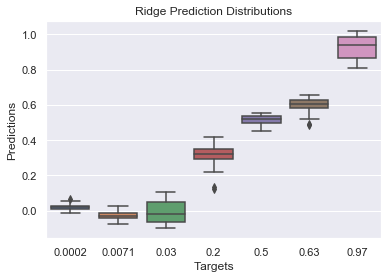

In [88]:
grouped_predictions(best_ridge)
plt.title("Ridge Prediction Distributions")

Text(0.5, 1.0, 'Lasso Prediction Distributions')

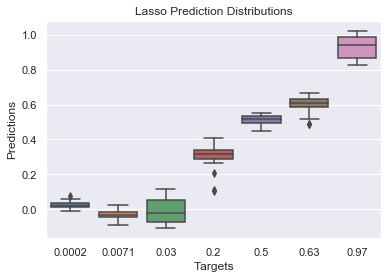

In [87]:
grouped_predictions(best_lasso)
plt.title("Lasso Prediction Distributions")

Text(0.5, 1.0, 'Elastic Net Prediction Distributions')

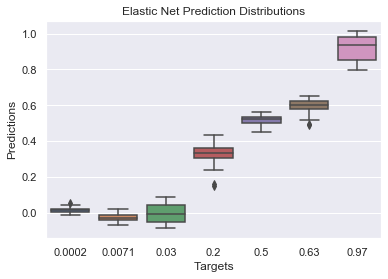

In [89]:
grouped_predictions(best_elastic)
plt.title("Elastic Net Prediction Distributions")

Text(0.5, 1.0, 'Decision Tree Prediction Distributions')

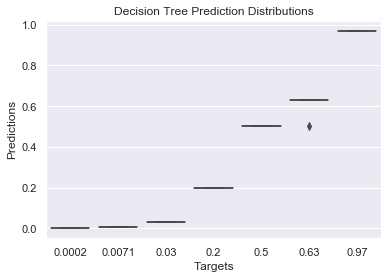

In [86]:
grouped_predictions(best_tree_reg)
plt.title("Decision Tree Prediction Distributions")

Text(0.5, 1.0, 'Random Forest Prediction Distributions')

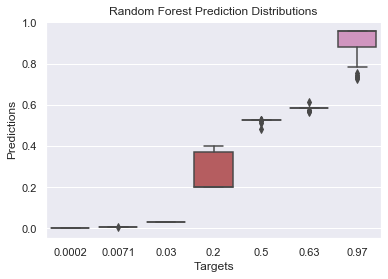

In [85]:
grouped_predictions(best_for_reg)
plt.title("Random Forest Prediction Distributions")

Text(0.5, 1.0, 'Adaptive Boosting Prediction Distributions')

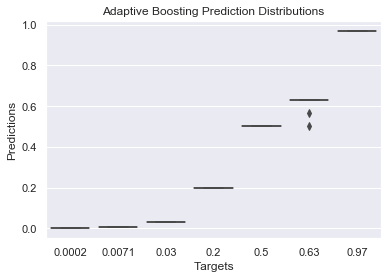

In [84]:
grouped_predictions(ada_reg)
plt.title("Adaptive Boosting Prediction Distributions")

In [48]:
results_noise, names = reg_comp(seed=42, X_train=X_train, 
        y_train=y_train,
        X_test=X_test, y_test=y_test,
        ridge=best_ridge, decision_tree=best_tree_reg,
        lasso=best_lasso, elastic_net=best_elastic,
        random_forest=best_for_reg,
        adaboost_reg=ada_reg)

Model: Mean (Standard Deviation)
Ridge: 0.053011 (0.047384)
Lasso: 0.053375 (0.045211)
Elastic Net: 0.052893 (0.050450)
Decision Tree: 0.000464 (0.007755)
Random Forest: 0.029912 (0.054643)
AdaBoost Forest: 0.000696 (0.008658)


In [49]:
results_noise

[array([0.08015146, 0.17852172, 0.04530062, 0.03050125, 0.12593096,
        0.1314912 , 0.04371737, 0.01389029, 0.04893112, 0.02224566,
        0.04294588, 0.03964974, 0.09421319, 0.10277815, 0.02002097,
        0.00120475, 0.04852532, 0.15196724, 0.11168877, 0.0432008 ,
        0.00285636, 0.09570319, 0.08607836, 0.06638648, 0.00025379,
        0.06836827, 0.03963224, 0.00542275, 0.04623334, 0.03182612,
        0.12729803, 0.00559075, 0.01858991, 0.09146504, 0.0339753 ,
        0.01573587, 0.1237267 , 0.1334401 , 0.08390183, 0.02059275,
        0.07194621, 0.06708945, 0.01271769, 0.01217032, 0.03562181,
        0.02030125, 0.01747354, 0.04006299, 0.020538  , 0.10318051,
        0.08295782, 0.02750984, 0.00355026, 0.0193861 , 0.00663181,
        0.00447146, 0.0249615 , 0.02785681, 0.0710004 , 0.01251992,
        0.05217804, 0.06975298, 0.01899134, 0.01834108, 0.03607242,
        0.0239567 , 0.05223298, 0.10494253, 0.00210922, 0.00380726,
        0.0004595 , 0.01101653, 0.13199571, 0.02

In [50]:
best_tree_reg.fit(X_train, y_train)
pred = best_tree_reg.predict(X_test)
aes = abs(pred - y_test)
print(aes)

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.13
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0

In [53]:
y_test

array([2.0e-01, 2.0e-01, 7.1e-03, 2.0e-04, 3.0e-02, 2.0e-01, 3.0e-02,
       5.0e-01, 5.0e-01, 2.0e-04, 5.0e-01, 5.0e-01, 2.0e-01, 2.0e-01,
       3.0e-02, 3.0e-02, 2.0e-04, 2.0e-01, 3.0e-02, 7.1e-03, 7.1e-03,
       3.0e-02, 3.0e-02, 2.0e-01, 7.1e-03, 7.1e-03, 7.1e-03, 6.3e-01,
       6.3e-01, 2.0e-04, 2.0e-01, 2.0e-04, 5.0e-01, 2.0e-01, 7.1e-03,
       2.0e-04, 3.0e-02, 2.0e-01, 9.7e-01, 6.3e-01, 7.1e-03, 6.3e-01,
       2.0e-04, 5.0e-01, 3.0e-02, 5.0e-01, 6.3e-01, 5.0e-01, 7.1e-03,
       2.0e-01, 2.0e-01, 7.1e-03, 2.0e-04, 6.3e-01, 6.3e-01, 2.0e-04,
       3.0e-02, 5.0e-01, 3.0e-02, 2.0e-04, 3.0e-02, 7.1e-03, 5.0e-01,
       5.0e-01, 2.0e-04, 5.0e-01, 6.3e-01, 3.0e-02, 3.0e-02, 5.0e-01,
       6.3e-01, 2.0e-04, 2.0e-01, 5.0e-01, 3.0e-02, 3.0e-02, 5.0e-01,
       7.1e-03, 5.0e-01, 9.7e-01, 3.0e-02, 5.0e-01, 2.0e-04, 2.0e-01,
       2.0e-01, 6.3e-01, 9.7e-01, 3.0e-02, 5.0e-01, 2.0e-04, 7.1e-03,
       2.0e-04, 5.0e-01, 2.0e-04, 9.7e-01, 5.0e-01, 6.3e-01, 6.3e-01,
       7.1e-03, 5.0e

In [52]:
y_test[111]

0.63

In [54]:
ada_reg.fit(X_train, y_train)
pred = ada_reg.predict(X_test)
aes = abs(pred - y_test)
print(aes)
print(y_test)

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.065 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.13  0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0

In [55]:
y_test[41]

0.63

In [56]:
y_test[111]

0.63

In [57]:
print(pred[41])
print(pred[111])

0.565
0.5
